# Success-Score

This notebook is intended to function as the final step in the Success-Score calculation, accessing the required functions for space and ball control to calculate the Success-Score based on the formula developed by (Perl & Memmert, 2017) <br>

The Success-Score function will allow for the passing of different interval lengths and areas, a space control rate that defines space control events and possibily further features <br>


#### References:
Perl, J., & Memmert, D. (2017). A Pilot Study on Offensive Success in Soccer Based on Space and Ball Control – Key Performance Indicators and Key to Understand Game Dynamics. International Journal of Computer Science in Sport, 16(1), 65–75. https://doi.org/10.1515/ijcss-2017-0005


In [1]:
from floodlight import Pitch
from floodlight.io import dfl
from pies import SuccessScore as ss
import numpy as np
from scipy.stats import pointbiserialr as pbr
import copy
import matplotlib.pyplot as plt


In [2]:
# read position data and match information file
position_file = 'PositionData/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-0027AD.xml'
matchinfo ='MI_Data/DFL_02_01_matchinformation_DFL-COM-000001_DFL-MAT-0027AD-Copy1.xml'

# returns multipe objects; at this point we only care about the positions (xy_objects) and the pitch object (pitch)
xy_objects, possession_objects, ballstatus_objects, teamsheets, pitch = dfl.read_position_data_xml(filepath_positions=position_file,
                          filepath_mat_info=matchinfo)

In [3]:
# space control rates
SCR_A1, SCR_B1, SCR_A2, SCR_B2, dvm1, dvm2 = ss.Space_Control(pos_data=xy_objects, pitch=pitch, area='penalty area', resolution= 10)


In [4]:
# ball control events
BC_A1, BC_B1, BC_A2, BC_B2 =ss.Ball_Control(pos_data = xy_objects, pitch = pitch,
                                                                                    area='penalty area', direction_A1= 'ltr',
                                                                                    method = 'dfl',
                                                                                    possession_object=possession_objects)

## Effort 

Or-Sum of ball and space control events in interval devided by interval length

In [5]:
t0 = 0           # start of interval (in s)
i = 100          # interval length in seconds
Hz = 25          # frames per second
bv = 20          # boarder value for SCR to SC-event
bc = BC_A1       # ball control vector
sc = SCR_A1      # space control vector

E = 0    # Effort or-sum

T0 = t0*Hz
I = i *Hz

for t in range(T0, I):
    if bc[t] == 1 or sc[t] >= bv:
        E = E+1
E/I


0.1076

## Efficiency

point biseral correlation between ball control events and space control rate over interval

In [6]:

t = 100            # point of interest (in s)
i = 100          # interval length in seconds
Hz = 25          # frames per second

T = t*Hz         # frame number
I = i *Hz        # number of frames
T0 = T-I         # start frame

bc = BC_A1       # ball control vector
sc = SCR_A1      # space control vector


BC = bc[T0:T]
SC = sc[T0:T].flatten()


pbr(BC, SC)



SignificanceResult(statistic=0.11616007923940358, pvalue=5.71719023363411e-09)

# Success-Score
Calculate both Effort and Efficiency per frame (over an interval) and multiply with each other. <br>
Loop over all frames <br>
Consider downsizing (1Hz) of data to decrease computing power <br> 

In [7]:
def Success_Score(position_file, matchinfo, area = 'penalty area', ball_control_method = 'dfl',
                  space_control_resolution = 10, space_control_mesh = 'square', direction_A1 = 'ltr',
                 direction_A2 = None, interval_length = 100, Hz = 1, space_control_rate = 20,
                 ball_control_distance = 1, negatives = False):
    

    # read position data and match information file
    position_file = 'PositionData/DFL_04_02_positions_raw_DFL-COM-000001_DFL-MAT-0027AD.xml'
    matchinfo ='MI_Data/DFL_02_01_matchinformation_DFL-COM-000001_DFL-MAT-0027AD-Copy1.xml'

    # returns multipe objects; at this point we only care about the positions (xy_objects) and the pitch object (pitch)
    xy_objects, possession_objects, ballstatus_objects, teamsheets, pitch = dfl.read_position_data_xml(filepath_positions=position_file,
                              filepath_mat_info=matchinfo)
    
    # determine the scaling factor for the downsizing of the data
    org_framerate = xy_objects['firstHalf']['Home'].framerate
    if Hz != org_framerate:
        if org_framerate % Hz == 0 and xy_objects['firstHalf']['Home'].framerate > Hz:
            factor = int(org_framerate/Hz)
        else:
            raise ValueError(f'Current framerate is {org_framerate} and cannot be converted to {Hz}; please chose a Hz that the framerate ca be divided by')
        print(factor)
        # downscale the data to Hz by scalign factor
        xy_object2 = copy.deepcopy(xy_objects)
        xy_object2['firstHalf']['Home'].xy = (xy_object2['firstHalf']['Home'].xy[::factor,:])
        xy_object2['firstHalf']['Away'].xy = (xy_object2['firstHalf']['Away'].xy[::factor,:])
        xy_object2['secondHalf']['Home'].xy = (xy_object2['secondHalf']['Home'].xy[::factor,:])
        xy_object2['secondHalf']['Away'].xy = (xy_object2['secondHalf']['Away'].xy[::factor,:])
    
    else:
        xy_object2 = copy.deepcopy(xy_objects)
        
    
    # space control rates
    SCR_A1, SCR_B1, SCR_A2, SCR_B2, dvm1, dvm2 = ss.Space_Control(pos_data=xy_object2, pitch=pitch, area=area,
                                                      resolution= space_control_resolution, meshtype = space_control_mesh,
                                                      direction_A1= direction_A1, direction_A2 = direction_A2)
    
    # we only need the values (array)
    SCR_A1 = SCR_A1.property.flatten()
    SCR_B1 = SCR_B1.property.flatten()
    SCR_A2 = SCR_A2.property.flatten()
    SCR_B2 = SCR_B2.property.flatten()
    # ball control events
    BC_A1, BC_B1, BC_A2, BC_B2 =ss.Ball_Control(pos_data = xy_object2, pitch = pitch, area='penalty area',
                                                direction_A1= direction_A1, direction_A2 = direction_A2,
                                                method = ball_control_method, possession_object=possession_objects, 
                                               distance = ball_control_distance)
    
    
    # if ball control is the dfl vector, we need to downsize those as well
    if Hz != org_framerate and ball_control_method == 'dfl':
        BC_A1 = BC_A1[::factor]
        BC_B1 = BC_B1[::factor]
        BC_A2 = BC_A2[::factor]
        BC_B2 = BC_B2[::factor]

    BC = [BC_A1, BC_B1, BC_A2, BC_B2]
    SCR = [SCR_A1, SCR_B1, SCR_A2, SCR_B2]
    
    # store space control rates and ball control events
    SpaceControlRate = {'A1': SCR_A1,
                        'B1': SCR_B1,
                        'A2': SCR_A2,
                        'B2': SCR_B2}
    
    BallControl = {'A1': BC_A1,
                   'B1': BC_B1,
                   'A2': BC_A2,
                   'B2': BC_B2}
    
    
    # to store EFFORT per frame for each team in each half; start with a zero for frame 1 (no calculation possible!)
    EFFORT = {'A1': [0],
              'B1': [0],
              'A2': [0],
              'B2': [0]}
    EK = list(EFFORT.keys())
    
    # to store EFFICIENCY per frame for each team in each half
    EFFICIENCY = {'A1': [0],
                  'B1': [0],
                  'A2': [0],
                  'B2': [0]}
    
    # to store EFFICIENCY per frame for each team in each half
    SUCCESSSCORE = {'A1': [],
                    'B1': [],
                    'A2': [],
                    'B2': []}
    
    # for each team in each half
    for th,TH in enumerate(BC): 
        
        L = len(TH)                       # number of frames
        #print(L, len(SCR[th]))
        IL = interval_length * Hz         # length of interval in number of frames
        
        # EFFORT
        
        # for each frame in that half for that team (t = Point of Success-Score)
        for t in range(1, L):
            E = 0             # Effort or-sum
            if t < IL:        # timepoint of calculation less than 1 interval length away from zero?
                T0 = 0        # start calculation at 0 (i.e. shorter interval)
                IL2 = t       # means our interval is only as long as the value of t
            else:
                T0 = t - IL   # start at t0 of the interval
                IL2 = IL      # interval is as long as it was supposed to be

            # for each frame in the interval from T0 to t 
            E = 0
            for T in range(T0, t):
                if BC[th][T] == 1 or SCR[th][T] >= space_control_rate:       # counts to effort if either ball control or space control rate > value
                    E = E+1
            
            EFFORT[EK[th]].append(E/IL2)                  # append Effort for each Interval / t | Effort = or-sum / interval length
        
        # EFFICIENCY
        
        # for each frame in that half for that team (t = Point of Success-Score)
        for t in range(1, L):
            
            if t < IL:                               # timepoint of calculation less than 1 interval length away from zero?
                T0 = 0                               # start calculation at 0 (i.e. shorter interval)
            else:
                T0 = t - IL                          # start at t0 of the interval
            BC_int = BC[th][T0:T]                    # Ball control for each frame in that interval
            #print(BC_int)
            SCR_int = SCR[th][T0:T]        # Space control rate for each frame in that interval
            #print(SCR_int)
            r, p = pbr(BC_int, SCR_int)
            EFFICIENCY[EK[th]].append(r)  

        # SUCCESS-SCORE
        
        # it is a fair assumption that in almost all cases an interval full of identical ball control events (either 0 or 1)
        # are zeros (100 seconds ball control in area less likely than 100 seconds no ball control in area) 
        # so we make it zero if it is not calculatable
        EFFICIENCY[EK[th]] = np.nan_to_num(EFFICIENCY[EK[th]], nan=0)
        # if we work under the assumption that negative correlation is no worse than no correlation at all we neutralize all negative correlations
        if negatives == False:
            EFFICIENCY[EK[th]][EFFICIENCY[EK[th]]<0] = 0

        for t in range(0, L):
            SUCCESSSCORE[EK[th]].append(EFFICIENCY[EK[th]][t] * EFFORT[EK[th]][t])
            
            
            
            
            
        
        
    return(SUCCESSSCORE, EFFORT, EFFICIENCY, SpaceControlRate, BallControl)


## Different areas

+ penalty area 
+ final third
+ 30m 
+ half
+ full (not recommended)

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


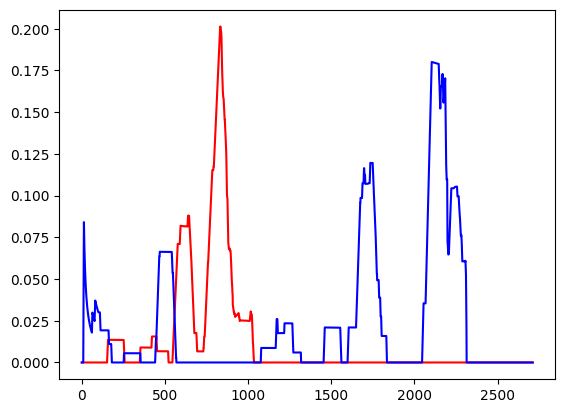

In [8]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'penalty area')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


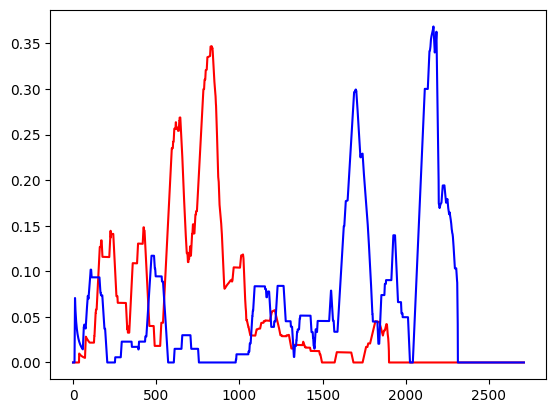

In [9]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'final third')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


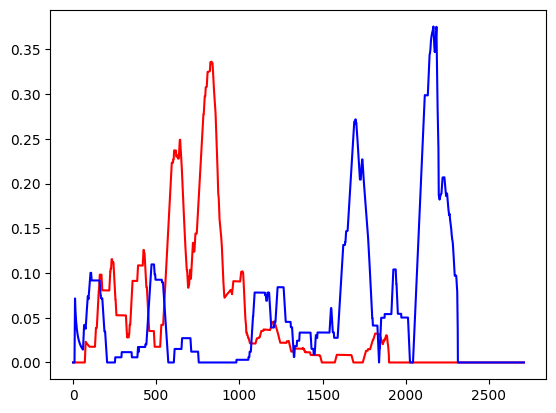

In [10]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = '30m')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


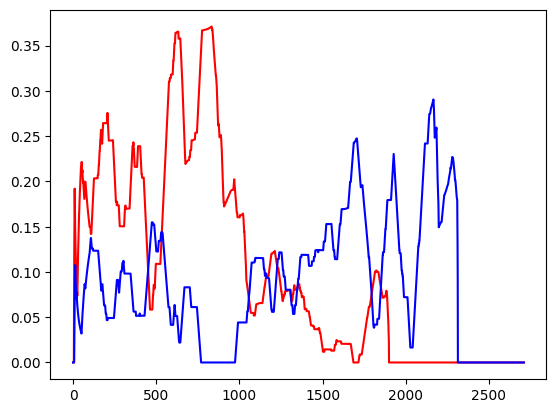

In [11]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'half')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25
Do you really care about the space control on the entire pitch?
Do you really care about the space control on the entire pitch?


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


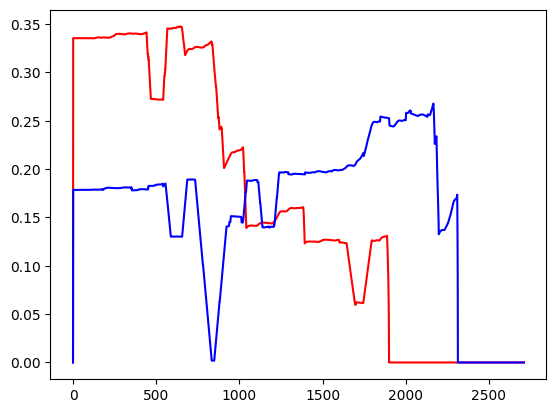

In [12]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'full')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


## Interval length
 
recommended range 100-600 seconds (Brinkjans et al., 2022, submitted; Perl & Memmert, 2017)

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


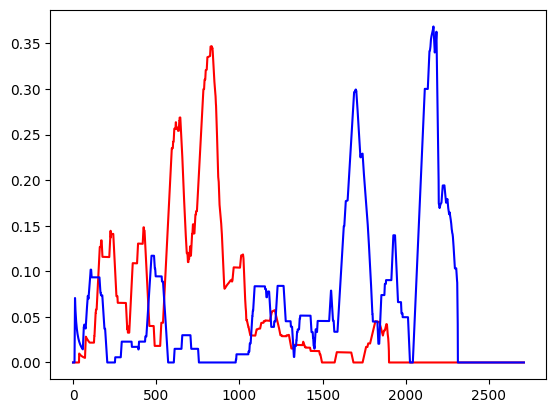

In [13]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=100,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'final third')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


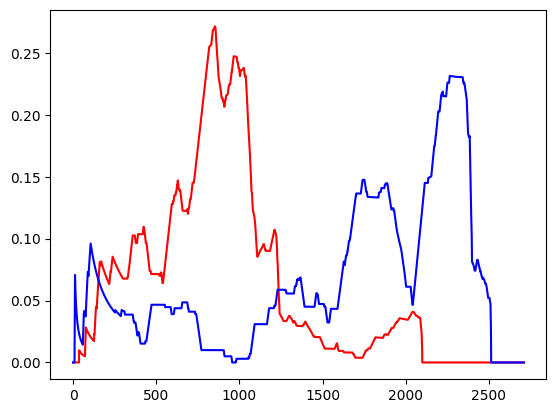

In [14]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'final third')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25


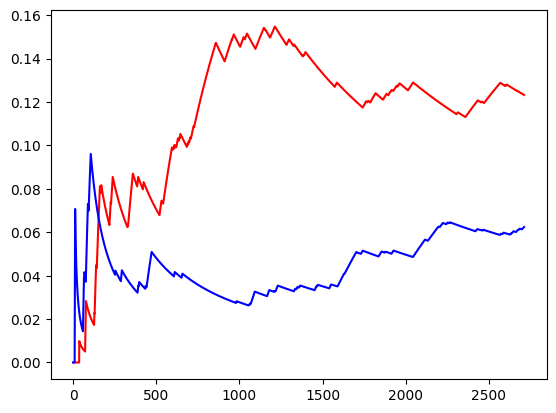

In [15]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=2712,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'final third')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


## Minimum Space control rate for space control event

20% has been validated. Feel free to experiment with the effect of different ones. There are certainly arguments for higher and lower rates, partially depending on the area analyzed (Brinkjans et al., 2022, submitted; Perl & Memmert, 2017).

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


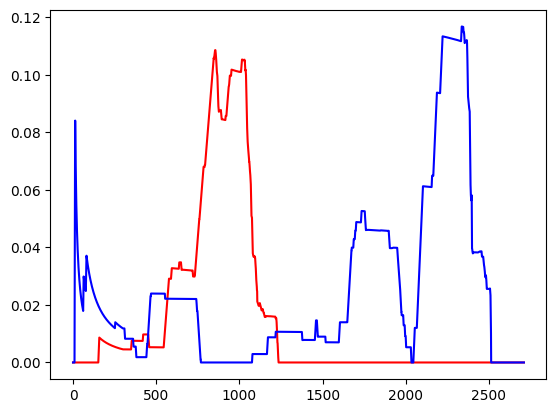

In [16]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'penalty area')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


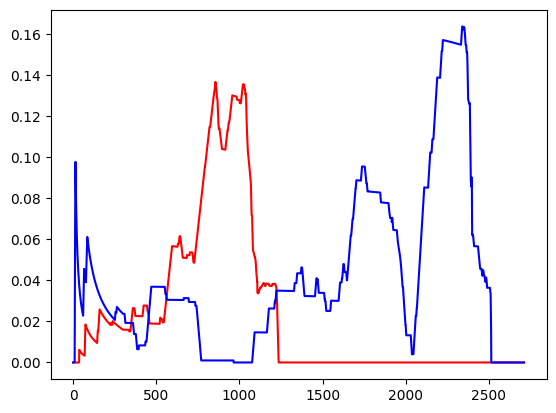

In [17]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo, space_control_rate= 7.5,
                                                                           area = 'penalty area')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

## Spatial Resolution of space control

Trade-off between computing time and accuracy of space control model. <br>
Optimum depends on purpose and area analyzed!

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


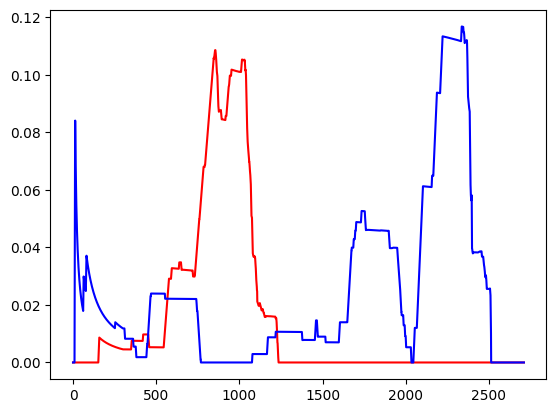

In [18]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'penalty area', space_control_resolution=10)

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


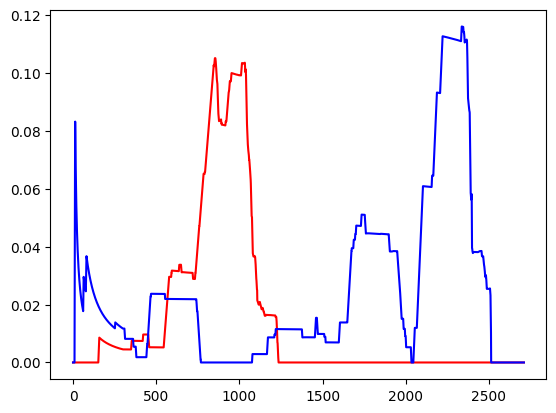

In [19]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo, space_control_rate= 20,
                                                                           area = 'penalty area', space_control_resolution = 50)

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


## Temporal resolution

Options dependent on framerate of original position data! <br>
Success-Score validated with 1 Hz (Brinkjans et al., 2022, submitted; Perl & Memmert, 2017). <br> 

Consider interpretability, computing power and accuracy.


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


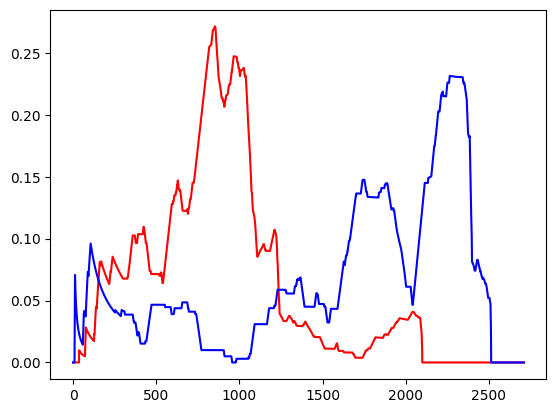

In [20]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo,
                                                                           area = 'final third')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


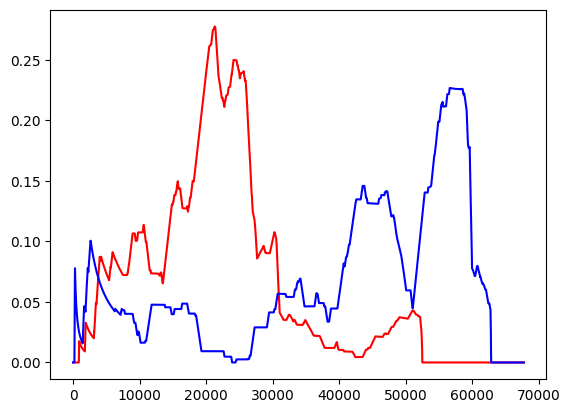

In [21]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo,
                                                                           area = 'final third', Hz = 25)

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')


## Ball control method and distance

'dfl' relies on the possession information provided within the data and tends to be more liberal in attributing possession. The alternative is to assess the closests player for both teams and whether they and no one of the opponents is closer than the defined distance. <br>
This approach is obviously not without limitations! It frequently severely underestimates the frequency of ball control events. <br>


25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


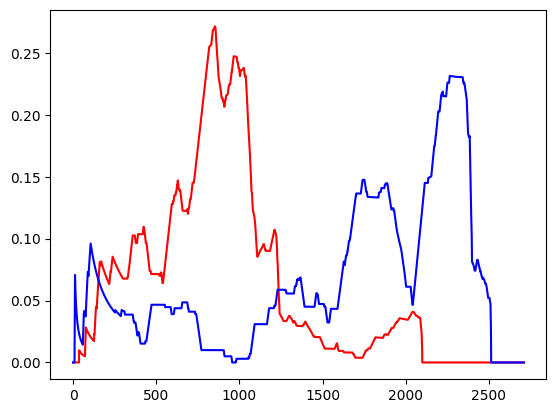

In [22]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo, area = 'final third')                                                                      
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


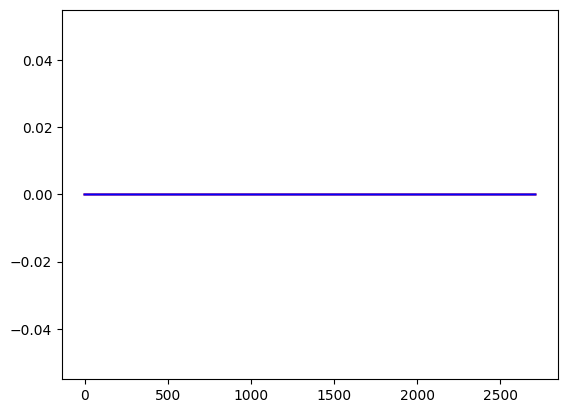

In [23]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo,
                                                                           area = 'final third',
                                                                           ball_control_method = 'custom')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

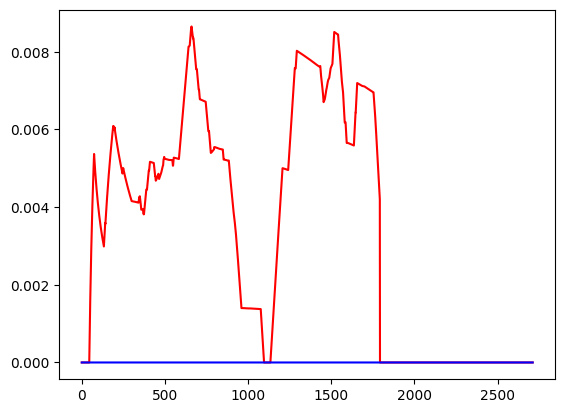

In [24]:
plt.plot(np.arange(0, len(SuccessScore['B2'])), SuccessScore['B2'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B2'])), SuccessScore['A2'], color = 'blue')

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


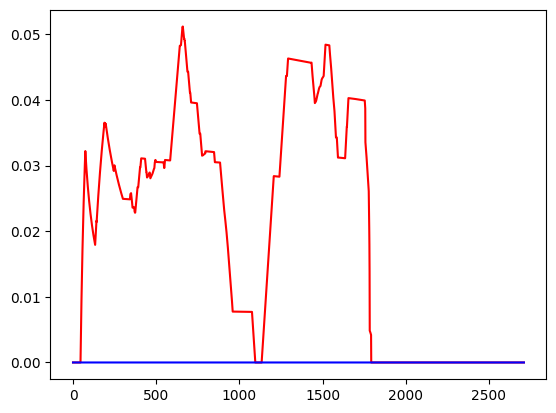

In [25]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo,
                                                                           area = 'final third',
                                                                           ball_control_method = 'custom',
                                                                           ball_control_distance = 2)

plt.plot(np.arange(0, len(SuccessScore['B2'])), SuccessScore['B2'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B2'])), SuccessScore['A2'], color = 'blue')

## Space control mesh

Floodlight allows to calculate the space control based on two different kinds of mesh grids. Hexagonal and square.
For Details check: https://floodlight.readthedocs.io/en/latest/modules/models/space.html <br>
Can but does not necessarily make a difference. Just compete in mind the whole space control is an estimation! <br>

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


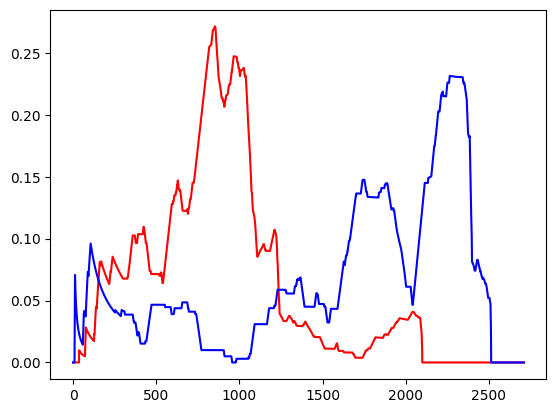

In [26]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo,
                                                                           area = 'final third',
                                                                           space_control_mesh='square')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


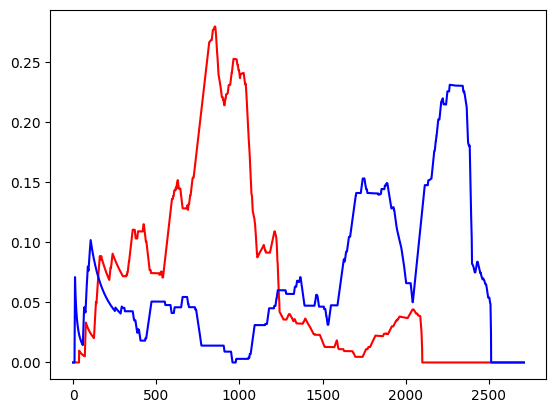

In [27]:
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = Success_Score(position_file=position_file, interval_length=300,
                                                                             matchinfo = matchinfo,
                                                                           area = 'final third',
                                                                           space_control_mesh='hexagonal')

plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

## Importing and using the function - All in one

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


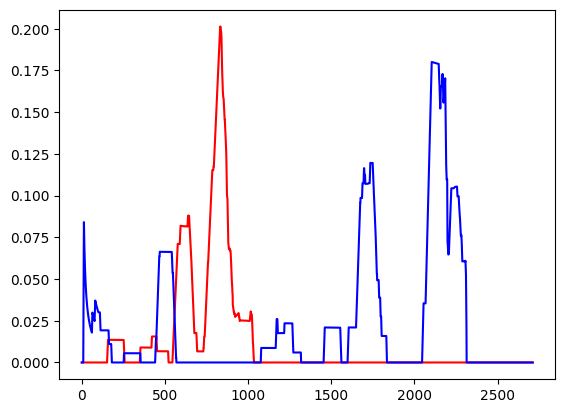

In [28]:
from pies import SuccessScore as ss
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = ss.Success_Score(position_file=position_file,
                                                                               matchinfo = matchinfo, space_control_rate= 20,
                                                                               area = 'penalty area')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')

25


C:\Users\DavidB\PythonProjects\SuccessScore\SuccessScore_venv\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


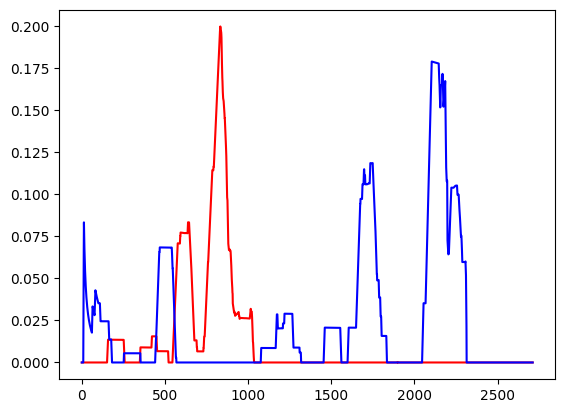

In [29]:
from pies import SuccessScore as ss
SuccessScore, Effort, Efficiency, SpaceControl, BallControl = ss.Success_Score(position_file=position_file, 
                                                                               matchinfo = matchinfo, space_control_rate= 20,
                                                                               area = 'penalty area', 
                                                                              space_control_mesh='hexagonal')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['B1'], color = 'red')
plt.plot(np.arange(0, len(SuccessScore['B1'])), SuccessScore['A1'], color = 'blue')